In [1]:
import math, random
import pandas as pd
import pygraphviz as pgv
from matplotlib import pyplot as plt

class Node:
    def __init__(self, name, typ):
        self.name = name
        self.type = typ
        self.children = {}
        self.info_gained = 0.0

In [2]:
def entropy(dataframe):
    data = dataframe["Party?"].tolist()
    classes = set(data)
    h = 0
    for c in classes:
        f = data.count(c)
        p = f / len(data)
        if p > 0:
            h = h + p * math.log(p, 2)
    return -h

In [3]:
def findBestFeature(dataframe):
    h0 = entropy(dataframe)
    max_feature = dataframe.columns[0]
    max_loss = 0
    columns = dataframe.columns.tolist()
    columns = columns[1:-1] #removed first and last columns
    for feature in columns: 
        hf = 0
        for value in set(dataframe[feature]):
            newD = dataframe[dataframe[feature] == value]
            pv = len(newD) / len(dataframe)
            hv = entropy(newD)
            hf = hf + pv * hv
        Lf = h0 - hf
        if Lf > max_loss:
            max_loss = Lf
            max_feature = feature
    return max_feature, max_loss

In [4]:
def TreeLearn(D):
    if entropy(D) == 0:
        cls = D.iloc[0,-1]
        leaf = Node(cls, 'leaf')
        return leaf
    f, info = findBestFeature(D)
    node = Node(f, 'internal')
    node.info_gained = info
    for value in set(D[f]):
        newD = D[D[f] == value]
        if newD.empty:
            continue
        else:
            child = TreeLearn(newD)
            node.children[value] = child
    return node

In [5]:
def print_helper(t, n):
    t.add_node(n, label = n.name + ': ' + str(n.info_gained))
    if n.type == 'internal':
        for value, node in n.children.items():
            t.add_edge(n, node, label = value)
            print_helper(t, node)

def print_tree(node):
    tree = pgv.AGraph(directed = True)
    print_helper(tree, node)
    tree.layout(prog="dot")
    tree.draw("party_tree.png")

In [6]:
def total_length(node, length): 
    if node.type == 'leaf':
        return length
    else:
        total = 0
        for n in node.children.values():
            total += total_length(n, length+1)
        return total

def number_of_leaves(node):
    if node.type == 'leaf':
        return 1
    else:
        total = 0
        for n in node.children.values():
            total += number_of_leaves(n)
        return total

def avg_length(node):
    return total_length(node, 0) / number_of_leaves(node)

In [7]:
party_data = pd.read_csv("house-votes-84.csv")

party_data.head()

,Label,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,Party?
0,P1,n,y,n,y,y,y,n,n,n,y,?,y,y,y,n,y,republican
1,P2,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,?,republican
2,P3,?,y,y,?,y,y,n,n,n,n,y,n,y,y,n,n,democrat
3,P4,n,y,y,n,?,y,n,n,n,n,y,n,y,n,n,y,democrat
4,P5,y,y,y,n,y,y,n,n,n,n,y,?,y,y,y,y,democrat


In [8]:
#node = TreeLearn(party_data)
#print_tree(node)
#print("Average Length:", avg_length(node))

In [9]:
def accuracy_check(node, testset):
    num_correct = 0
    for index, row in testset.iterrows():
        temp_node = node
        while temp_node.type != 'leaf':
            if row[temp_node.name] == '?':
                row[temp_node.name] = random.choice(('y', 'n'))
            temp_node = temp_node.children[row[temp_node.name]]
        if temp_node.name == row['Party?']:
            num_correct += 1
    return num_correct / 50

Text(0,0.5,'Percent Co')

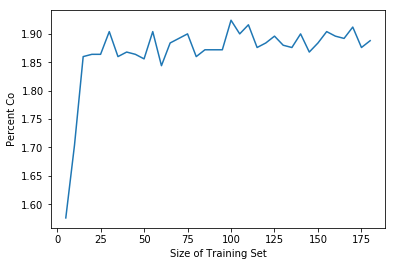

In [15]:
xvalues = []
yvalues = []

for i in range(5, 182, 5):
    
    total_percent = 0
    for j in range(10):
        testset = party_data.sample(n=50)
        temp_party_data = party_data.drop(testset.index)
    
        for col in temp_party_data.columns:
            temp_party_data = temp_party_data[temp_party_data[col] != '?']
    
        trainset = temp_party_data.sample(n=i)
        node = TreeLearn(trainset)
        total_percent += accuracy_check(node, testset)
    
    xvalues.append(i)
    yvalues.append(total_percent/5)

plt.plot(xvalues, yvalues)
plt.xlabel("Size of Training Set")
plt.ylabel("Percent Co")